Este script aprovecha al máximo la capacidad de el cambio de domino de rotaciones de la QFT al hacer una suma de dos números

Lo que va a hacer es:
- Asignaremos dos números al circuito, a y b
- Al número b se le aplicará la transformada cuántica de Fourier
- El número a nos servirá para aplicar rotaciones controladas al número detrás de la QFT
- Se aplica la transformada quántica inversa de Fourier para obtener el valor
- El valor de la suma se ve representado en el número b, así que se mide

In [73]:
import numpy as np
from qiskit import QuantumCircuit, transpile, assemble, QuantumRegister, ClassicalRegister
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector

In [74]:
# Este representa el primer número a sumar (el control)
a = 0b1010

# Este representa el segundo número a sumar, que será al que se le aplica la transformada de Fourier
b = 0b1100

In [75]:
bitsA = a.bit_length()
vectorA = np.array(range(bitsA))

bitsB = max(b.bit_length(), bitsA)
vectorB = np.array(range(bitsB)) + bitsA

n = bitsA + bitsB

print(n)

8


In [86]:
print("Resultado esperado:", bin((a + b) % (1<< bitsB))[2:].zfill(bitsB))

Resultado esperado: 0110


In [76]:
def fullSwap(circuit, qubits):
    n = len(qubits) - 1
    for i in range(len(qubits)//2):
        circuit.swap(qubits[i], qubits[n - i])
    return circuit

def qft(circuit, qubitsToTranform):
    for i, q in enumerate(reversed(qubitsToTranform)):
        circuit.h(q)
        for j, cq in enumerate(list(reversed(qubitsToTranform))[i+1:]):
            circuit.cp(np.pi/(2**(j + 1)), cq, q)
        circuit.barrier()
    return fullSwap(circuit, qubitsToTranform)

def invQft(circuit, qubitsToTransform):
    circuit = fullSwap(circuit, qubitsToTransform)
    for i, q in enumerate(qubitsToTransform):
        if i != 0:
            for j, cq in enumerate(reversed(qubitsToTransform[:i])):
                circuit.cp(2*np.pi - np.pi/(2**(j + 1)), cq, q)
        circuit.h(q)
        circuit.barrier()
    return circuit

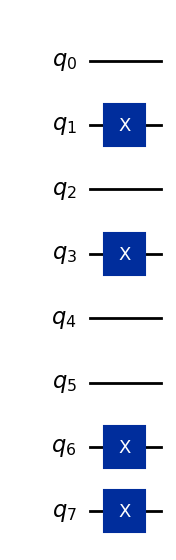

In [77]:
qr = QuantumRegister(n, name="q")
cr = ClassicalRegister(bitsB, name="c")

circuitCode = QuantumCircuit(qr)
for i in range(bitsA):
    if a & (1<<i):
        circuitCode.x(i)

for i in range(bitsB):
    if b & (1<<i):
        circuitCode.x(bitsA + i)

circuitCode.draw("mpl")

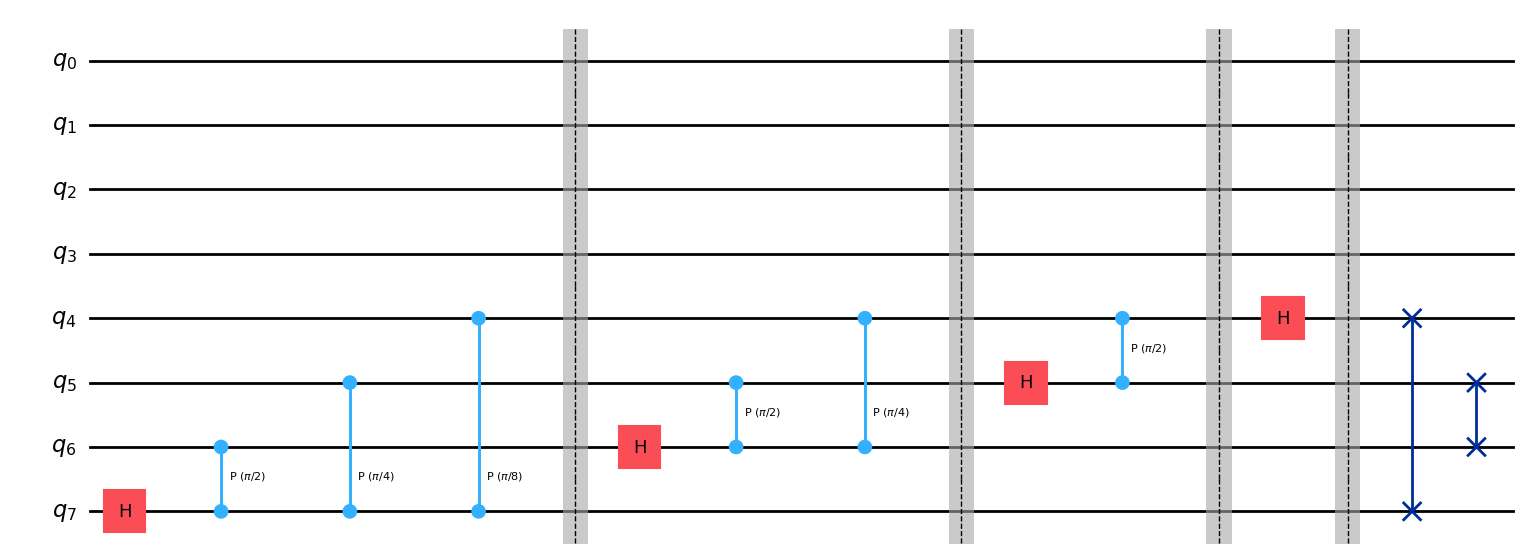

In [78]:
circuitQFT = QuantumCircuit(qr)
circuitQFT = qft(circuitQFT, vectorB)
circuitQFT.draw("mpl")


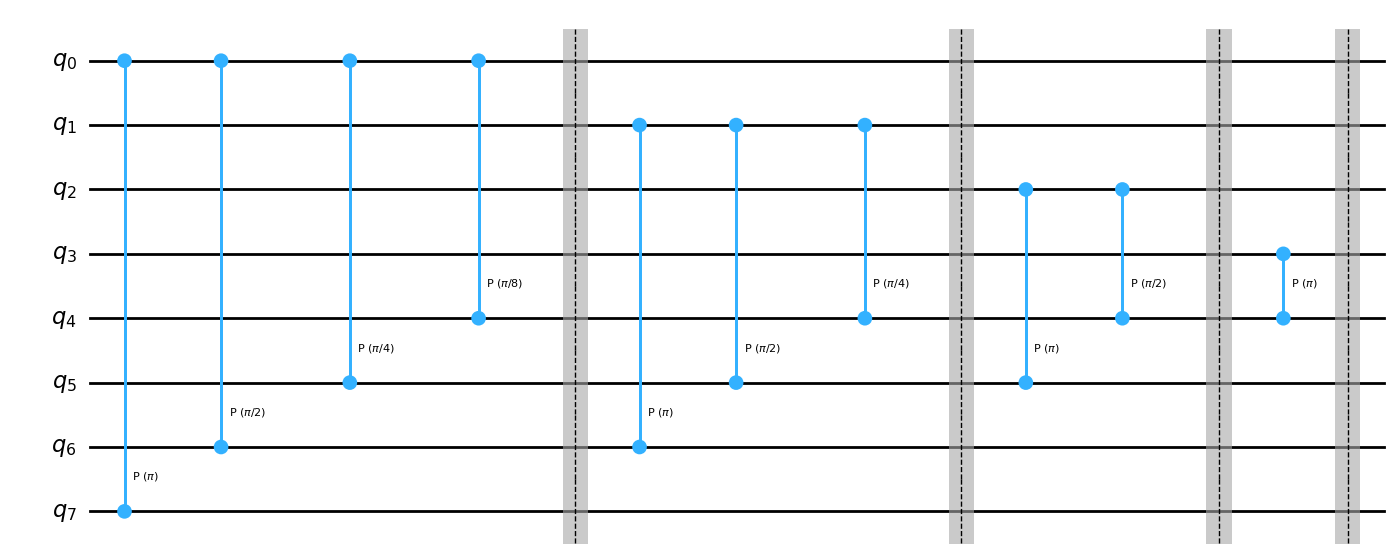

In [79]:
circuitAdder = QuantumCircuit(qr)
for i, qi in enumerate(vectorA):
    for j, qj in enumerate(reversed(vectorB)):
        theta = 2**i * np.pi / 2**j
        if not (theta / (2 * np.pi)).is_integer():
            circuitAdder.cp(theta, qi, qj)
    circuitAdder.barrier()
circuitAdder.draw("mpl")

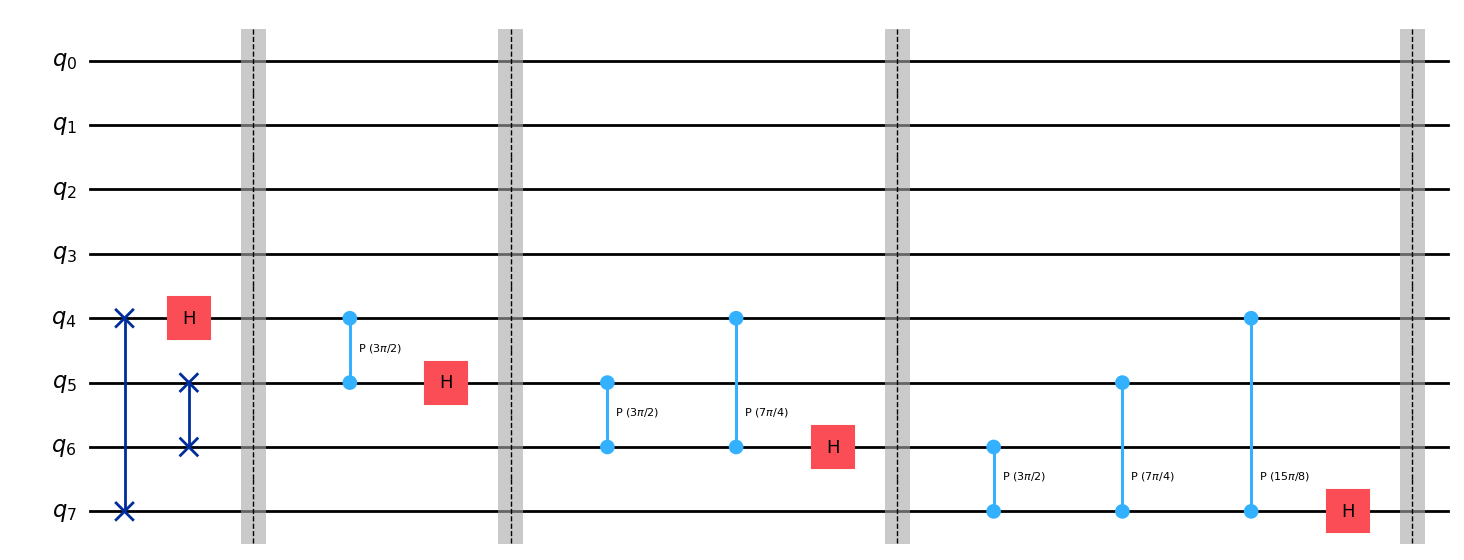

In [80]:
circuitInvQFT = QuantumCircuit(qr)
circuitInvQFT = invQft(circuitInvQFT, vectorB)
circuitInvQFT.draw("mpl")

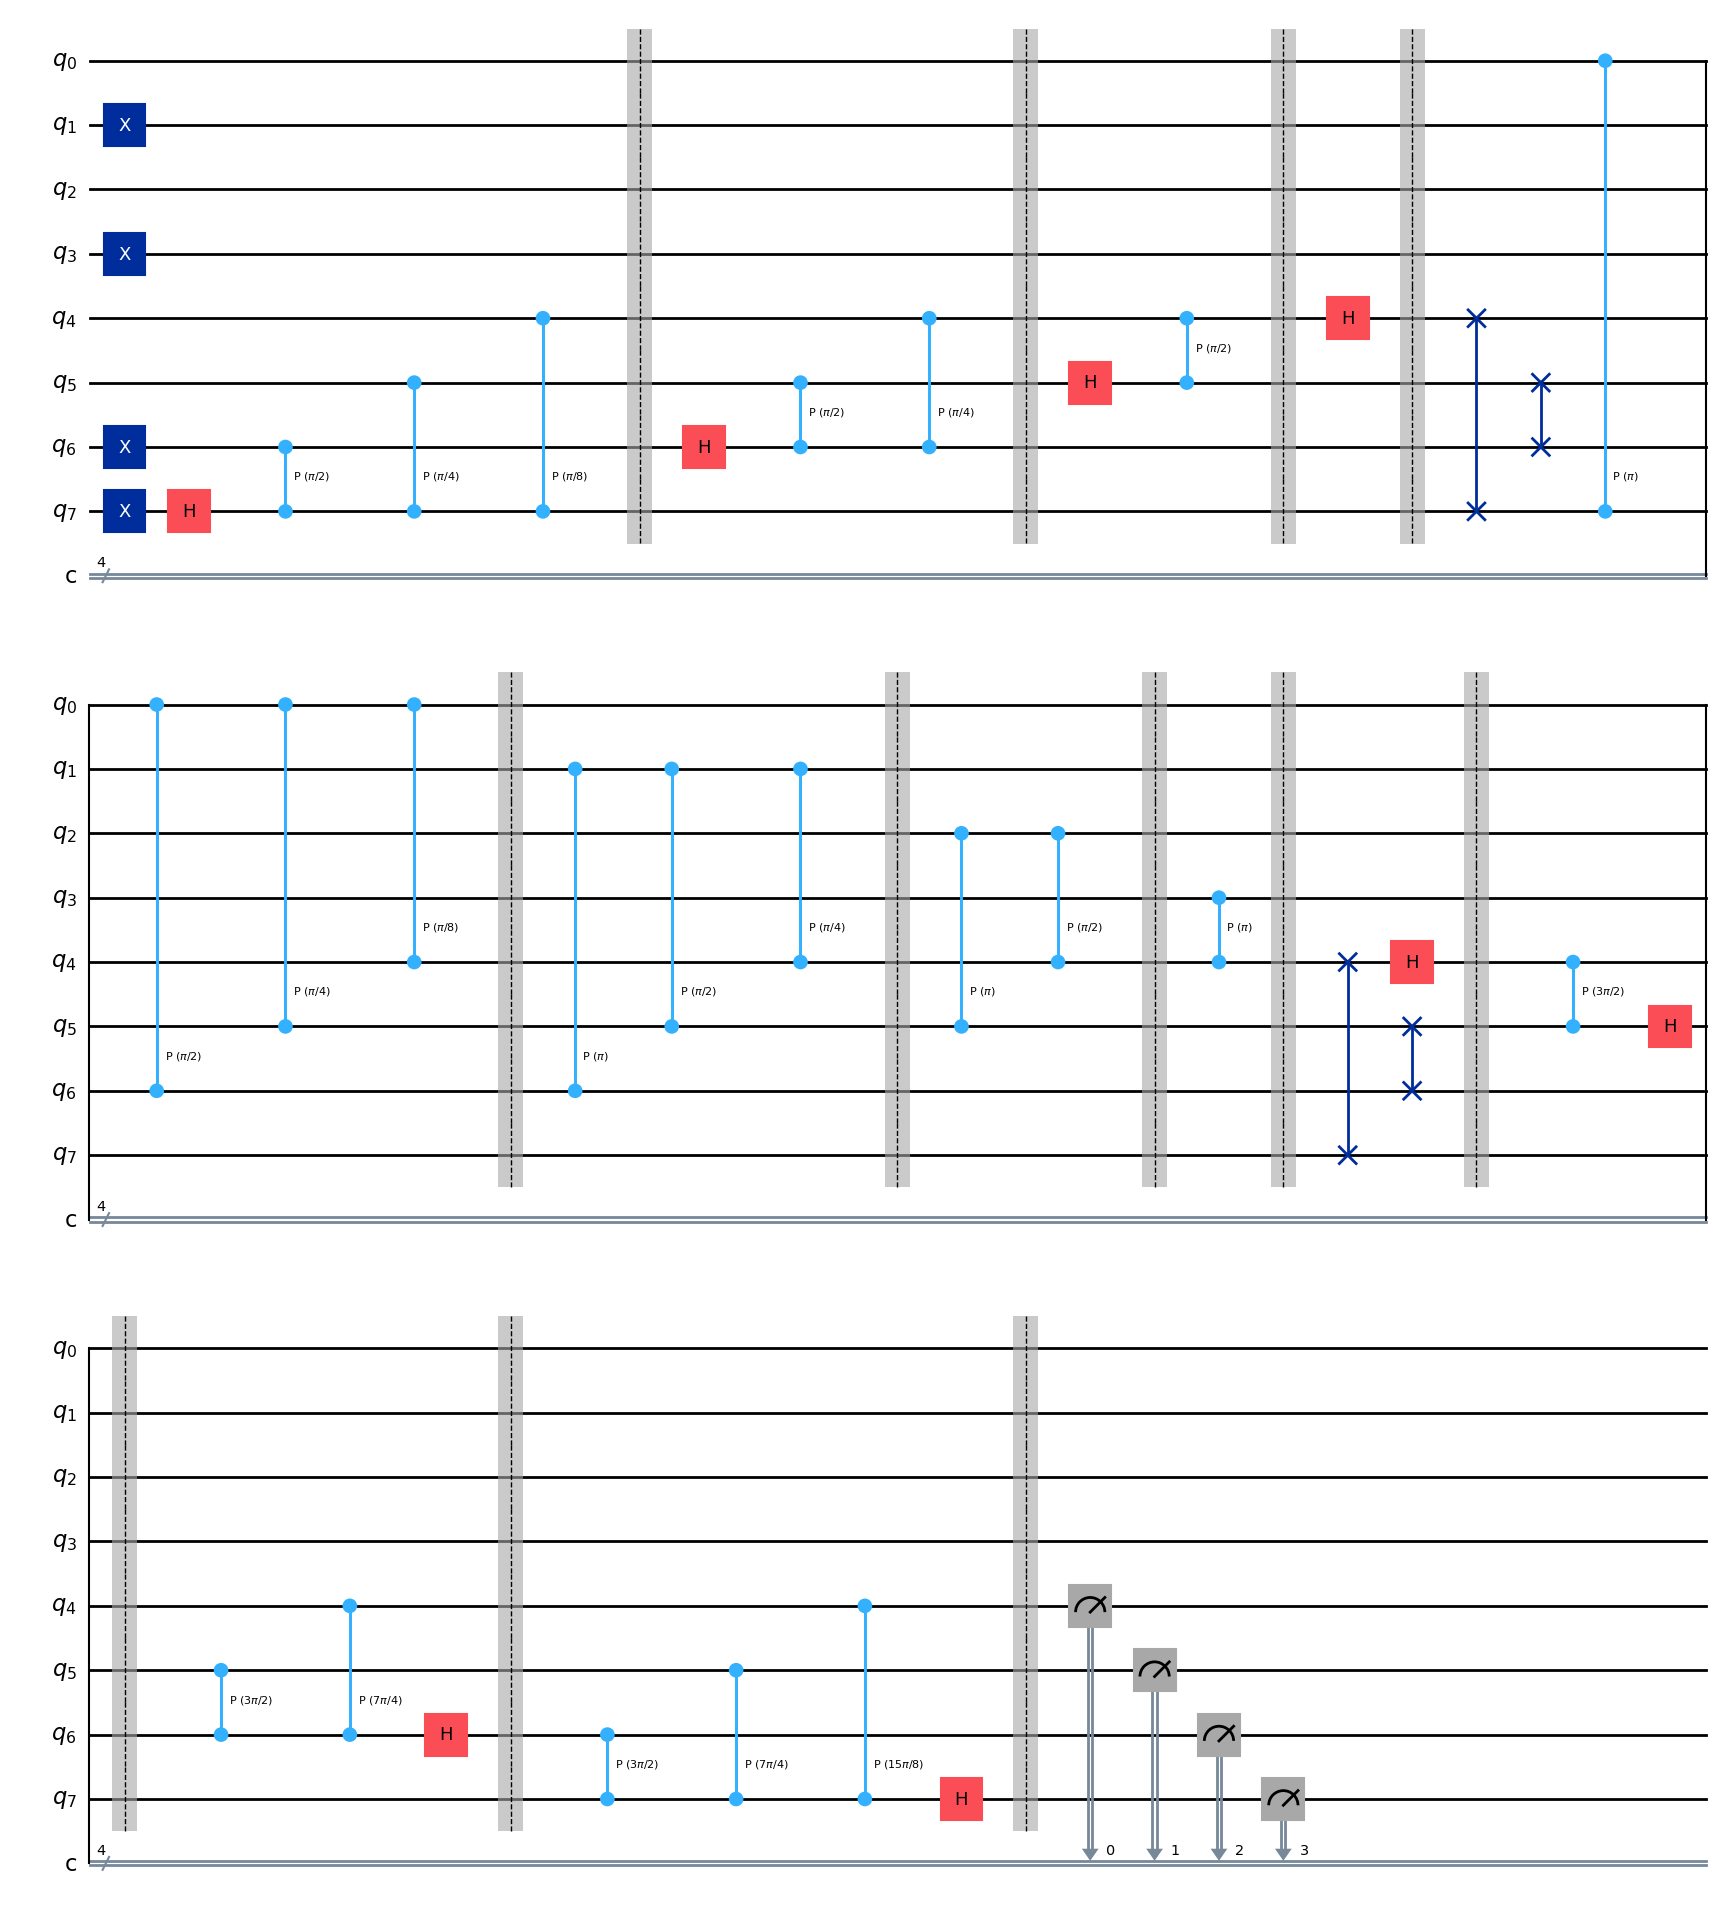

In [81]:
circuit = QuantumCircuit(qr, cr)
circuit.compose(circuitCode, inplace=True)
circuit.compose(circuitQFT, inplace=True)
sv1 = Statevector.from_instruction(circuit)
circuit.compose(circuitAdder, inplace=True)
sv2 = Statevector.from_instruction(circuit)
circuit.compose(circuitInvQFT, inplace=True)
sv3 = Statevector.from_instruction(circuit)

circuit.measure(vectorB, range(bitsB))

circuit.draw("mpl")

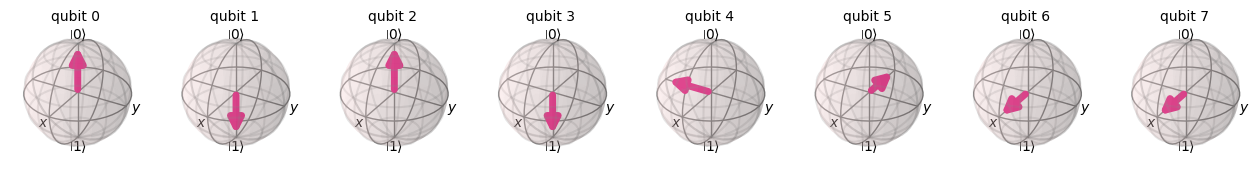

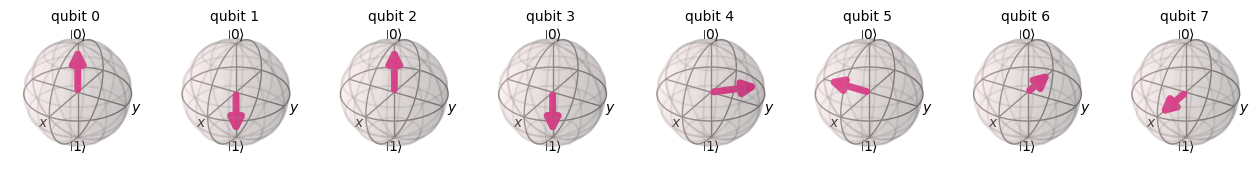

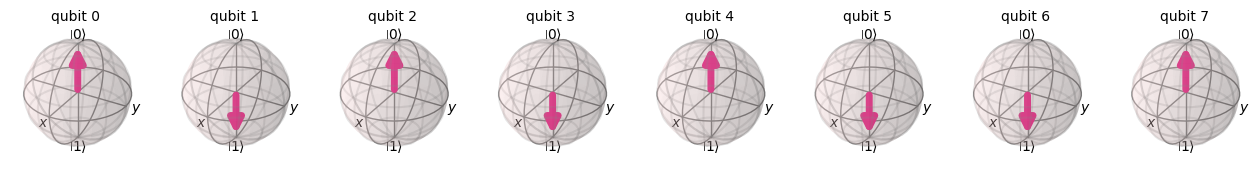

In [82]:
display(sv1.draw("bloch"))
display(sv2.draw("bloch"))
display(sv3.draw("bloch"))

In [83]:
backend = Aer.get_backend('statevector_simulator')

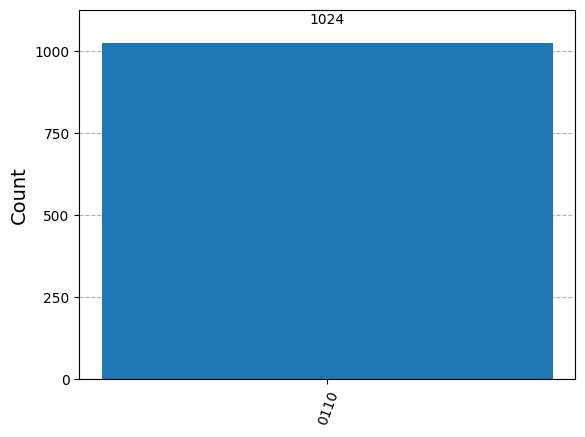

In [84]:
counts = backend.run(transpile(circuit, backend), shots=1024).result().get_counts()
plot_histogram(counts)

In [96]:
print("Resultado obtenido:", list(counts.keys())[0])

Resultado obtenido: 0110
